## Determining the Optimum Population Size 

For this analysis, the Erdos-Renyi and Log-Normal graph models are used as representatives of the overall topology series in order to determine the optimum population size for the standard GA over static networks. 

In [1]:
import time 
import random
import numpy as np
import itertools
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt

**Graph Generation**

In [2]:
# Generate coordinates for n nodes 
# n: Number of nodes 
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

# Calculate the straight line distance between coordinates  
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair 
# b: Second coordinate pair 
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

def depth_factor(i, j):
    return np.exp(-pythag(i, j))

def surface_factor(si, sj):
    return (si + sj)

def nx_log_normal(size, degree):
    # Generate coordinates in range [0, 1]
    scale = 1
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node 
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define the surface factor between every node pair 
    # Larger surfaces have greater probability to connect 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
    
    # Define the depth factor between every pair of nodes 
    # Geometrically closer nodes have higher depth factor 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Calculate the existence probability for each edge 
    # depth_factor_ij * surface_factor_ij 
    ep = np.multiply(df, sf)
    total_ep = np.sum(ep)
    
    # Roulette wheel 
    # Create an edge (i, j) with Pr. proportional to ep_ij 
    edges_set = []
    
    while degree > 0:
        pr_sum = 0.0 
        ptr = random.random()
        
        for i, j in itertools.product(range(size), range(size)):
                if i == j:
                    continue 
                
                pr = ep[i][j] / total_ep
                pr_sum += pr 
                
                if pr_sum > ptr: 
                    edges_set.append((i, j, {'weight': pr}))
                    break
        
        degree = degree - 1 
    
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(edges_set)
    
    return G 

def nx_connected_ln(size, degree):
    # Set a hard limit on the number of models generated
    # before exit
    max_iterations = 10 
    
    # Generate models until connected
    for i in range(max_iterations):
        G = nx_log_normal(size, degree)
        
        # Check if G is connected 
        connected = True
        for node in range(size):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return (connected, G)
    
    # Return the false flag and null model
    return (False, None)

def connected_ln(size, degree):
    a, b = nx_connected_ln(size, degree)
    return b

In [3]:
def gen_erdos_renyi(n, p):
    # Create an empty networkx graph
    G = nx.Graph()
    
    # Add n nodes
    G.add_nodes_from(range(n))
    
    # Add possible edges with probability p
    # Disallow self-edges
    for i in range(n):
        for j in range(n):
            if i == j:
                continue 
            
            rnd = random.random()
            
            if rnd < p:
                G.add_edge(i, j)
    
    return G

def erdos_renyi(n, p):
    for i in range(1000):
        G = gen_erdos_renyi(n, p)
        
        # Check if G is connected 
        connected = True
        for node in range(n):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return G
    
    return None

In [4]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w = None):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

**Updated Graph Generation Below**

In [11]:
# ***
# Generate Log-Normal Distributed Graph 
# Generate coordinates for n nodes 
# n: Number of nodes 
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

# Calculate the straight line distance between coordinates  
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair 
# b: Second coordinate pair 
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

def depth_factor(i, j):
    return np.exp(-pythag(i, j))

def surface_factor(si, sj):
    return (si + sj)

def nx_log_normal(size, degree):
    # Generate coordinates in range [0, 1]
    scale = 1
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node 
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define the surface factor between every node pair 
    # Larger surfaces have greater probability to connect 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
    
    # Define the depth factor between every pair of nodes 
    # Geometrically closer nodes have higher depth factor 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Calculate the existence probability for each edge 
    # depth_factor_ij * surface_factor_ij 
    ep = np.multiply(df, sf)
    total_ep = np.sum(ep)
    
    # Roulette wheel 
    # Create an edge (i, j) with Pr. proportional to ep_ij 
    edges_set = []
    
    while degree > 0:
        pr_sum = 0.0 
        ptr = random.random()
        
        for i, j in itertools.product(range(size), range(size)):
                if i == j:
                    continue 
                
                pr = ep[i][j] / total_ep
                pr_sum += pr 
                
                if pr_sum > ptr: 
                    edges_set.append((i, j, {'weight': pr}))
                    break
        
        degree = degree - 1 
    
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(edges_set)
    
    return G 

# Get a connected log normal 
def connected_log_normal(size, degree):
    # Set a hard limit on the number of models generated
    # before exit
    max_iterations = 100
    
    # Generate models until connected
    for i in range(max_iterations):
        G = nx_log_normal(size, degree)
        
        # Check if G is connected 
        connected = True
        for node in range(size):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return G
    
    # Return the false flag and null model
    return None 


# ***
# Generate Barabasi-Albert Model 
def barabasi_albert_node(G, n):
    # Node & Degree for each node in G excluding new node 
    degree = [d for (n, d) in G.degree]
    # Probability for each node 
    # There are no edges from node n 
    pr = np.divide(degree, (2 * len(G.edges())))
    
    return np.random.choice(G.nodes(), p = pr)


def barabasi_albert_edge(G, n): 
    dest = barabasi_albert_node(G, n)
    edge = (n, dest)
    
    # Recurse to add new non-existing edge 
    if edge in G.edges():
        barabasi_albert_edge(G, n)
        return
    
    # Avoid self-edges
    # Self edges should not occur (probability to choose n is zero)
    # However, they do appear in this implementation FIX LATER
    if n == dest:
        barabasi_albert_edge(G, n)
        return
    
    G.add_edge(n, dest)
    
# Produce a scale-free network represented as a networkx graph 
#    object with initial size m and final size n
# m: Initial size of graph
# n: Final size of graph 
# return: Networkx graph model 
def barabasi_albert(m, n):
    # Begin with a fully connected graph size m
    G = nx.complete_graph(m)
    
    for n in range(m, n):
        G.add_node(n)
        
        # Connect new node to m existing nodes 
        for i in range(m):
            barabasi_albert_edge(G, n)
    
    return G 


# ***
# Generate a Watts-Strogatz Networkx graph 
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges

def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)
            
# Generate a networkx graph with small world properties (Watts-Strogatz)
def watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring


# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w = None):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w
            
            
def weighted_watts_strogatz(n, k, p):
    g = watts_strogatz(n, k, p)
    assign_random_weights(g, 0, 100)
    return g 


def weighted_log_normal(size, degree):
    g = connected_log_normal(size, degree)
    assign_random_weights(g, 0, 100)
    return g

def weighted_barabasi_albert(m, n):
    g = barabasi_albert(m, n)
    assign_random_weights(g, 0, 100)
    return g

**GA**

In [12]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

def fit(p, g):
    pl = path_length(p, g)
    
    if pl == 0:
        return 1
    else:
        return path_length(p, g) ** (-1)

# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

def mutate(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path

# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])
        
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# s: start node in path 
# d: destination node in path
# g; graph 
def ga(G, threshold, itr, p, r, m, s, d):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, s, d, p) 
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Track previo
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            c, d = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(c) 
            gen.append(d)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(G, gen[i]) 
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    runtime = time.time() - start 
    
    results = {"generations": count, "runtime": runtime,
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Test GA**

In [13]:
# DEPRICATED 
def trial(gen_graph, arg_a, arg_b, n_trials, P_SIZE):
    results = []
    
    for trial in range(n_trials):
        # Gen new random graph
        g = gen_graph(arg_a, arg_b)
        assign_random_weights(g, 1, 100)
        
        src, dst = np.random.choice(arg_a, size = 2, replace = False)
        
        # Run GA
        result = ga(g, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src, dst)
        
        # Append Fitmax for run 
        fitmax = [x for x, y, z in result["learning_history"]]
        results.append(fitmax)
    
    return results 

In [7]:
def experiment(gen_graph, arg_a, arg_b, n_trials, p_sizes):
    results = []
    
    for P_SIZE in p_sizes:
        trials = trial(gen_graph, arg_a, arg_b, n_trials, P_SIZE)
        results.append(np.mean(trials, axis = 0))
    
    return results 

In [8]:
# GA Hyperparameters 
THRESHOLD = 100          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 20          # Maximum iterations 
M_RATE = 0.025           # Mutation rate (percent of population to mutate)
R_RATE = 0.5             # Percent of population to select as parents

# Variables 
graph_sizes = [100, 225, 500]
p_sizes = [50, 75, 100]

# Experiment results for each graph size and type 
ln_results = {}
ws_results = {}
ba_results = {} 

for size in graph_sizes:
    ln_results[size] = experiment(connected_ln, size, (size * 5), 10, p_sizes)

KeyboardInterrupt: 

**Plots**

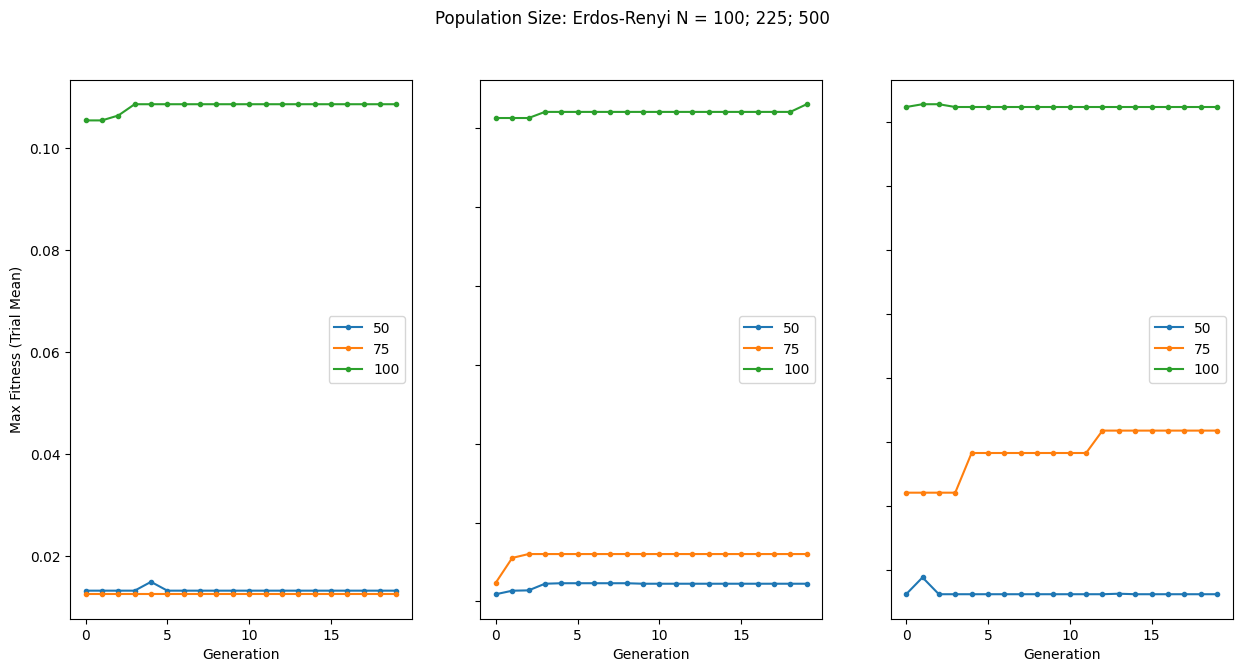

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Population Size: Erdos-Renyi N = 100; 225; 500')

# First plot (N = 100)
for x in er_results[100]:
    ax1.plot(x, marker = ".")

# Second plot (N = 225)
for x in er_results[225]:
    ax2.plot(x, marker = ".")

# Third plot (N = 500)
for x in er_results[500]:
    ax3.plot(x, marker = ".")
    
# Make ticks show on outter plot
for ax in fig.get_axes():
    ax.label_outer()

ax1.legend(("50", "75", "100"), loc = "best")
ax2.legend(("50", "75", "100"), loc = "best")
ax3.legend(("50", "75", "100"), loc = "best")
    
ax1.set(xlabel = "Generation", ylabel = "Max Fitness (Trial Mean)")
ax2.set(xlabel = "Generation")
ax3.set(xlabel = "Generation")

#plt.savefig("./plots/exp_1_optimum_pop/er_opt_pop.jpg", dpi = 300)

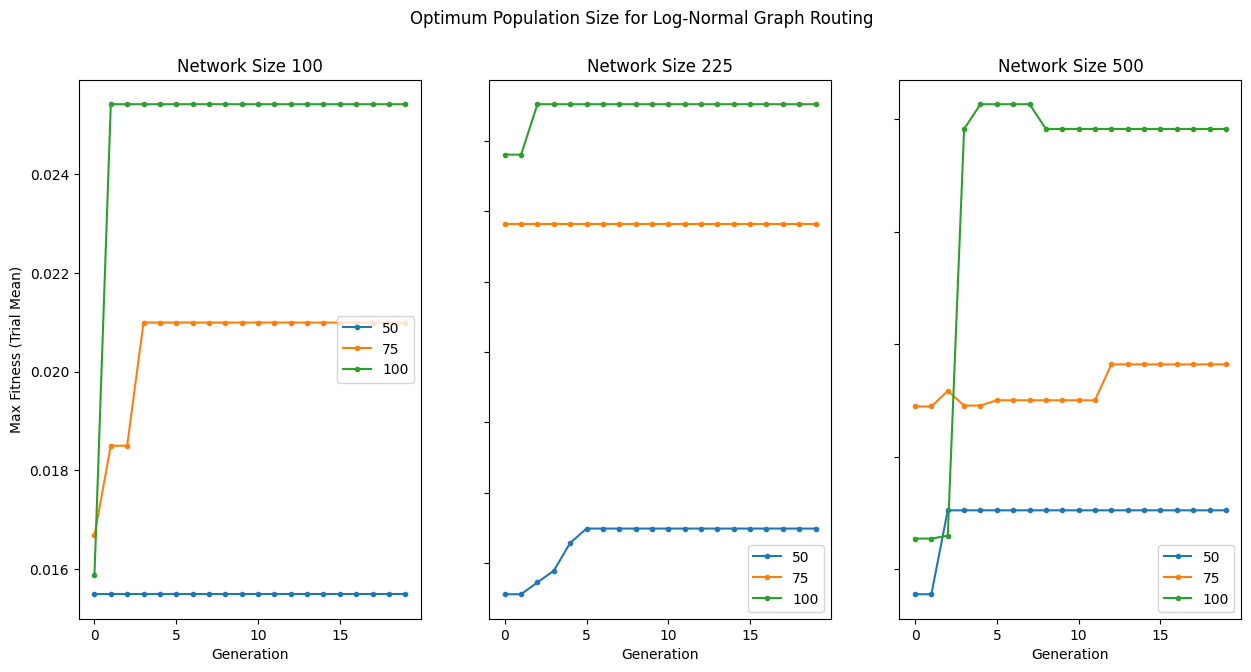

In [117]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Optimum Population Size for Log-Normal Graph Routing')

# First plot (N = 100)
for x in ln_results[100]:
    ax1.plot(x, marker = ".")

# Second plot (N = 225)
for x in ln_results[225]:
    ax2.plot(x, marker = ".")

# Third plot (N = 500)
for x in ln_results[500]:
    ax3.plot(x, marker = ".")

# Make ticks show on outter plot
for ax in fig.get_axes():
    ax.label_outer()
    
ax1.set_title("Network Size 100")
ax2.set_title("Network Size 225")
ax3.set_title("Network Size 500")

ax1.legend(("50", "75", "100"), loc = "right")
ax2.legend(("50", "75", "100"), loc = "best")
ax3.legend(("50", "75", "100"), loc = "best")
    
ax1.set(xlabel = "Generation", ylabel = "Max Fitness (Trial Mean)")
ax2.set(xlabel = "Generation")
ax3.set(xlabel = "Generation")

plt.savefig("./plots/exp_1_optimum_pop/ln_opt_pop.jpg", dpi = 300)

**Further Tests**

Based on the improved performance with a population size of 100 for each graph size, it is now tested for a 500 node Log-Normal graph whether a higher population size can be beneficial. 

In [119]:
# GA Hyperparameters 
THRESHOLD = 100          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 50          # Maximum iterations 
M_RATE = 0.03           # Mutation rate (percent of population to mutate)
R_RATE = 0.5             # Percent of population to select as parents

# At what point does performance degrade
p_sizes_2 = [100, 110, 120]
further_results = experiment(connected_ln, 500, 2500, 10, p_sizes_2) # Best of three

Text(0.5, 1.0, 'Optimum Population Size for Log-Normal (N = 500)')

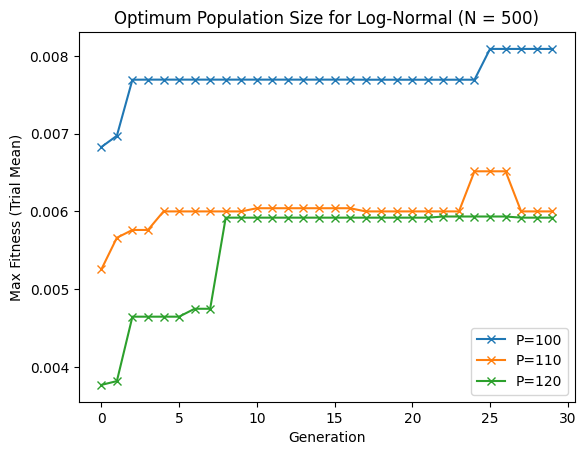

In [120]:
plt.figure()
for x in further_results:
    plt.plot(x, marker = "x")
plt.legend(("P=100", "P=110", "P=120"), loc = "best")
plt.ylabel("Max Fitness (Trial Mean)")
plt.xlabel("Generation")
plt.title("Optimum Population Size for Log-Normal (N = 500)")

**Optimum Population Size for WS, SF, LN size 500** 

In [16]:
# USE THIS ONE 
def trial(graph_type, trials, P_SIZE):
    results = [] 
    G = None 
    
    for trial in range(trials):
        if graph_type == "WS":
            G = weighted_watts_strogatz(500, 4, 0.25)
        elif graph_type == "BA":
            G = weighted_barabasi_albert(3, 500)
        else:
            G = weighted_log_normal(500, 2500)
        
        # For the new G 
        src, dst = np.random.choice(500, size = 2, replace = False)
        
        result = ga(G, 100, 50, P_SIZE, 0.5, 0.025, src, dst)
        
        # Append Fitmax for run 
        fitmax = [x for x, y, z in result["learning_history"]]
        results.append(fitmax)
    
    return np.mean(results, axis = 0)

In [17]:
p_sizes = [75, 100, 120]

ws_results = []
ba_results = []
ln_results = [] 

for p_size in p_sizes:
    ln_results.append(trial("LN", 10, 50))
    ws_results.append(trial("WS", 10, 50))
    ba_results.append(trial("BA", 10, 50))

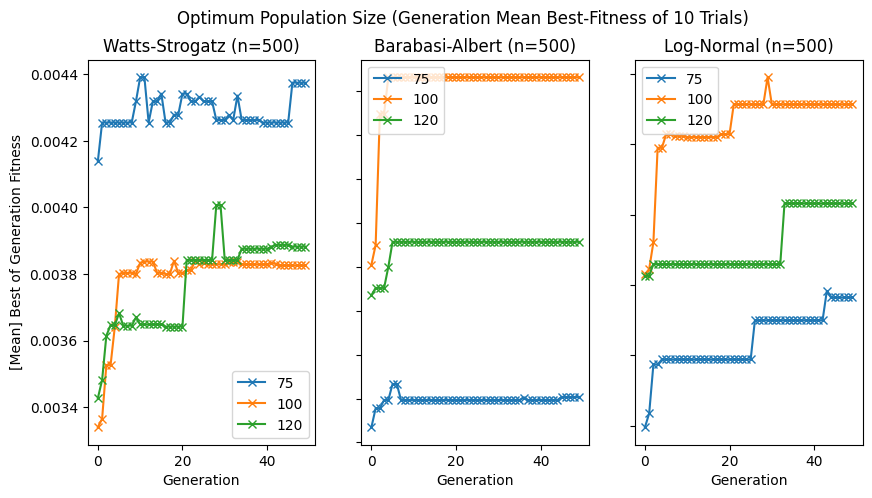

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(10, 5))
fig.suptitle('Optimum Population Size (Generation Mean Best-Fitness of 10 Trials)', fontsize = 12)

# First plot (WS N = 500) 
for x in ws_results:
    ax1.plot(x, marker = "x")
for x in ba_results:
    ax2.plot(x, marker = "x")
for x in ln_results:
    ax3.plot(x, marker = "x")
    
# Make ticks show on outter plot
for ax in fig.get_axes():
    ax.label_outer()
    
ax1.set_title("Watts-Strogatz (n=500)")
ax2.set_title("Barabasi-Albert (n=500)")
ax3.set_title("Log-Normal (n=500)")

ax1.legend(("75", "100", "120"), loc = "best")
ax2.legend(("75", "100", "120"), loc = "best")
ax3.legend(("75", "100", "120"), loc = "best")
    
ax1.set(xlabel = "Generation", ylabel = "[Mean] Best of Generation Fitness")
ax2.set(xlabel = "Generation")
ax3.set(xlabel = "Generation")

plt.savefig("./plots/exp_1_optimum_pop/ws_ba_ln_pop.jpg", dpi = 300)